In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [2]:
_image_dir = '../datasets/celeba/img_align_celeba_png/'
_img_width = 178
_img_height = 218
_batch_size = 16
_num_epochs = 20
_attributes = ['Eyeglasses', 'Smiling', 'Male', 'No_Beard', 'Young']

In [3]:
img_df = pd.read_csv('../datasets/celeba/attributes/attr_celeba.csv').replace({-1:0})[['filename', 'Eyeglasses', 'Smiling', 'Male', 'No_Beard', 'Young']]
partition_df = pd.read_csv('../datasets/celeba/attributes/list_eval_partition.csv')
img_df = img_df.merge(partition_df, on='filename')
img_df.loc[:, 'filename'] = img_df.loc[:, 'filename'].apply(lambda x: os.path.join(_image_dir, x))
img_df.head()

,filename,Eyeglasses,Smiling,Male,No_Beard,Young,partition
0,../datasets/celeba/img_align_celeba_png/000001...,0,1,0,1,1,0
1,../datasets/celeba/img_align_celeba_png/000002...,0,1,0,1,1,0
2,../datasets/celeba/img_align_celeba_png/000003...,0,0,1,1,1,0
3,../datasets/celeba/img_align_celeba_png/000004...,0,0,0,1,1,0
4,../datasets/celeba/img_align_celeba_png/000005...,0,0,0,1,1,0


In [4]:
train_df = img_df.loc[img_df.loc[:, 'partition'] == 0, ['filename', 'Eyeglasses', 'Smiling', 'Male', 'No_Beard', 'Young']]
valid_df = img_df.loc[img_df.loc[:, 'partition'] == 1, ['filename', 'Eyeglasses', 'Smiling', 'Male', 'No_Beard', 'Young']]
test_df = img_df.loc[img_df.loc[:, 'partition'] == 2, ['filename', 'Eyeglasses', 'Smiling', 'Male', 'No_Beard', 'Young',]]

In [5]:
train_datagen =  ImageDataGenerator(
#     rotation_range=30,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     brightness_range=[0.4,1.5],
    preprocessing_function=preprocess_input,
    rescale=1./255,
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    batch_size=_batch_size,
    x_col='filename', 
    y_col= _attributes,
    class_mode='raw',
    target_size=(_img_width, _img_height),
    validate_filenames=False)

Found 162770 non-validated image filenames.


In [6]:
valid_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255
)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    batch_size=_batch_size,
    x_col='filename', 
    y_col=_attributes,
    class_mode='raw',
    target_size=(_img_width, _img_height),
    validate_filenames=False)

Found 19867 non-validated image filenames.


In [7]:
base_model = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(_img_width, _img_height, 3))

print("number of layers:", len(base_model.layers))

# for layer in base_model.layers[:52]:
#     layer.trainable = False

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


number of layers: 311


In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
outputs = Dense(5, activation="sigmoid")(x)

In [9]:
model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [10]:
checkpointer = ModelCheckpoint(filepath='inception_v3_eyeglasses_smiling_male_nobeard_young.h5', verbose=1, save_best_only=True)

In [11]:
hist = model.fit_generator(train_generator,
                            validation_data = valid_generator,
                            steps_per_epoch= len(train_df)//_batch_size,
                            validation_steps=len(valid_df) // _batch_size,
                            epochs=_num_epochs,
                            callbacks=[checkpointer],
                            verbose=1,
                           )


Epoch 1/20
10173/10173 [==============================] - 1259s 124ms/step - loss: 0.1445 - accuracy: 0.9418 - val_loss: 0.1773 - val_accuracy: 0.9485

Epoch 00001: val_loss improved from inf to 0.17726, saving model to inception_v3_eyeglasses_smiling_male_nobeard_young.h5
Epoch 2/20
10173/10173 [==============================] - 1234s 121ms/step - loss: 0.1144 - accuracy: 0.9543 - val_loss: 0.1667 - val_accuracy: 0.9519

Epoch 00002: val_loss improved from 0.17726 to 0.16671, saving model to inception_v3_eyeglasses_smiling_male_nobeard_young.h5
Epoch 3/20
10173/10173 [==============================] - 1233s 121ms/step - loss: 0.0993 - accuracy: 0.9603 - val_loss: 0.0974 - val_accuracy: 0.9489

Epoch 00003: val_loss improved from 0.16671 to 0.09744, saving model to inception_v3_eyeglasses_smiling_male_nobeard_young.h5
Epoch 4/20
10173/10173 [==============================] - 1221s 120ms/step - loss: 0.0835 - accuracy: 0.9667 - val_loss: 0.1962 - val_accuracy: 0.9502

Epoch 00004: val_

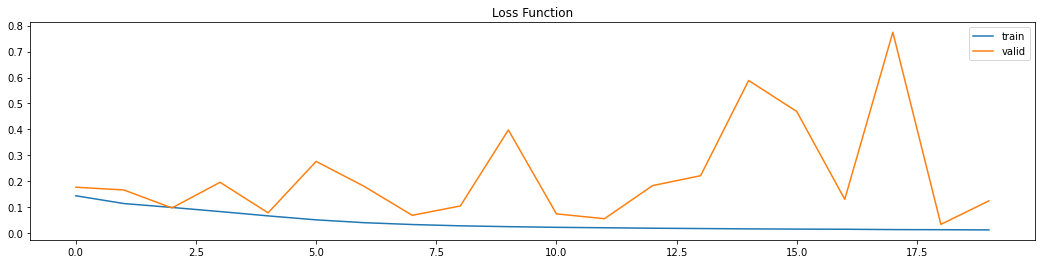

In [12]:
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

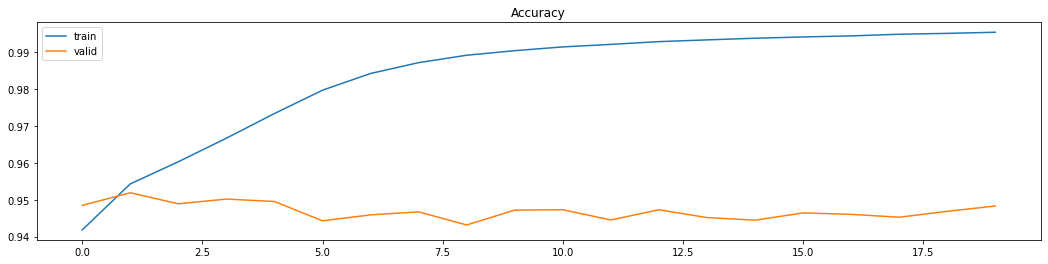

In [13]:
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [21]:
test_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255,
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    batch_size=1,
    x_col='filename', 
    y_col=_attributes,
    class_mode='raw',
    target_size=(_img_width, _img_height),
    validate_filenames=False,
    shuffle=False)

Found 19962 non-validated image filenames.


In [22]:
model.load_weights('inception_v3_eyeglasses_smiling_male_nobeard_young.h5')

In [23]:
model_predictions = model.predict(test_generator)
preds = np.array(model_predictions > 0.5).astype(int)

In [24]:
test_accuracy = 100 * accuracy_score(preds, test_df.loc[:, _attributes].values)
test_accuracy

75.90421801422703

In [25]:
f1 = f1_score(test_df.loc[:,  _attributes].values, preds, average='weighted')
f1

0.948216556076301

In [26]:
label_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1./255,
)

label_generator = label_datagen.flow_from_directory(
    './img',
    classes=['to_label2'],
    batch_size=1,
    target_size=(_img_width, _img_height),
    shuffle=False)

Found 256000 images belonging to 1 classes.


In [27]:
model_predictions = model.predict(label_generator)

In [49]:
np.set_printoptions(formatter={'float_kind':"{:.6f}".format})
print(model_predictions[154])

[0.999811 0.000009 0.999993 0.110903 0.230218]


In [29]:
import h5py
with h5py.File('sample_z2.h5', 'r') as f:
    z = f['z'][:]

In [30]:
from custom_gen import StyleGANGenerator
_stylegan_ffhq_f_gdrive_url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-ffhq-config-f.pkl'

gen = StyleGANGenerator(_stylegan_ffhq_f_gdrive_url)

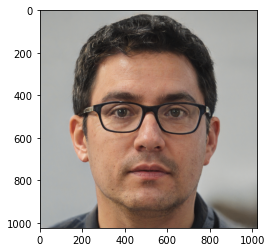

In [50]:
img = gen.get_images(np.reshape(z[154], (1,512)))
plt.imshow(img[0]/255)

In [32]:
import pickle
with open('predictions_inceptionv3_5attr.pkl', 'wb') as f:
    pickle.dump(model_predictions, f)

In [47]:
with open('predictions_inceptionv3_5attr.pkl', 'rb') as f:
    new = pickle.load(f)

In [51]:
new[154]

array([0.999811, 0.000009, 0.999993, 0.110903, 0.230218], dtype=float32)